# PyVista recipes

## Importing and configuring

In [1]:
from majordome import (
    FluentFvParticlesParser,
    centered_colormap
)
import pyvista as pv
import numpy as np

In [2]:
# No access to X server to avoid warnings:
pv.OFF_SCREEN = True

# Static backend with image dumping support:
pv.set_jupyter_backend("static")

## By project standard viewer

In [3]:
class CustomViewer:
    """ Provides custom visualization of CFD results. """
    slots = ("_theme", "_data")

    def __init__(self, data):
        self._theme = self.theme()
        self._data = data

    @staticmethod
    def theme():
        """ Default theme for rendering project CFD results. """
        theme = pv.themes.DocumentTheme()

        theme.background = "#EEEEEE"
        theme.jupyter_backend = "static"
        theme.window_size = [1000, 800]

        theme.font.color = "black"
        theme.font.size = 15
        theme.font.title_size = 20
        theme.font.label_size = 15

        theme.colorbar_orientation = "horizontal"
        theme.colorbar_horizontal.width  = 0.70
        theme.colorbar_horizontal.height = 0.09
        theme.colorbar_horizontal.position_x = 0.15
        theme.colorbar_horizontal.position_y = 0.03

        return theme

    def axes(self, plot, *, scale, pos):
        """ Default axes for rendering project CFD results. """
        axes = pv.AxesAssembly()

        axes.x_color = "#FAF000"
        axes.y_color = "#FAF000"
        axes.z_color = "#FAF000"

        # axes.x_label = ""
        # axes.y_label = ""
        # axes.z_label = ""

        axes.scale = scale
        axes.label_color = "black"
        axes.label_size = 10
        axes.position = pos

        plot.add_actor(axes)

    def camera(self, plot, *, scale, pos):
        """ Manage tight view and set image scale for standard images. """
        plot.reset_camera()
        plot.camera.zoom("tight")
        plot.camera_position = pos
        plot.camera.parallel_scale *= scale

    def plot(self, *, data=True, opts, camera_pos, axes_pos, camera_scale, axes_scale):
        """ Default plot for rendering CFD results over symmetry plane. """
        plot = pv.Plotter(theme=self._theme)

        if data:
            plot.add_mesh(self._data, **opts)

        self.camera(plot, scale=camera_scale, pos=camera_pos)
        self.axes(plot, scale=axes_scale, pos=axes_pos)
        return plot

    @staticmethod
    def dump(plot, fname):
        """ Dump a screenshot of current plot at given directory, if any. """
        plot.screenshot(fname, return_img=False, transparent_background=True)

    @property
    def fields(self):
        """ List all available fields for visualization. """
        return [key for key in self._data.point_data.keys()]

## By project custom loader

In [4]:
def custom_loader(fname):
    """ Provides a custom data loader for CFD results. """
    reader = pv.CGNSReader(fname)
    return reader.read()["Base"]["Zone"]

## Plot formatting

In [5]:
def options_outline(color="black", alpha=0.3):
    return {"color": color, "opacity": alpha}

In [6]:
def options_velocity(vmin=0, vmax=18, n_labels=9):
    opts = {
        "scalars": "VelocityMagnitude",
        "cmap": "jet",
        "clim": (vmin, vmax),
        "scalar_bar_args": {
            "title": "Velocity Magnitude [m/s]\n",
            "n_labels": n_labels,
            "fmt": "%.0f",
        }
    }
    return opts

In [7]:
def options_pressure(vmin=-120, vmax=240, vcenter=0.0):
    opts = {
        "scalars": "PressureStagnation",
        "cmap": centered_colormap("bwr", vmin, vmax, vcenter),
        "clim": (vmin, vmax),
        "scalar_bar_args": {
            "title": "Total Pressure [Pa]\n",
            "n_labels": 6,
            "fmt": "%.0f",
        }
    }
    return opts

## Loading and manipulating data

In [8]:
plane = custom_loader("sample/sample.cgns")
plane = plane.rotate_z(90, inplace=False)
plane

UnstructuredGrid (0x7f56acdd1ba0)
  N Cells:    1108
  N Points:   1958
  X Bounds:   -1.983e+00, 1.800e-01
  Y Bounds:   0.000e+00, 9.150e-01
  Z Bounds:   2.380e+01, 2.380e+01
  N Arrays:   7

In [9]:
conf = {
    "camera_pos": "xy",
    "camera_scale": 0.7,
    "axes_pos": (-2.7, -0.25, 23.8),
    "axes_scale": 0.3
}

In [10]:
viewer = CustomViewer(plane)
viewer.fields

['VelocityMagnitude',
 'Turbulent_Viscosity_Ratio',
 'PressureDynamic',
 'PressureStagnation']

In [11]:
opts = options_outline()
plot = viewer.plot(opts=opts, **conf)
plot.show()

In [12]:
opts = options_velocity(vmin=0, vmax=18, n_labels=9)
plot = viewer.plot(opts=opts, **conf)
plot.show()

In [13]:
opts = options_pressure(vmin=-10, vmax=140, vcenter=90.0)
plot = viewer.plot(opts=opts, **conf)
plot.show()

## Particle tracking (*WIP*)

In [14]:
tracks = FluentFvParticlesParser("sample/sample.fvp")
tracks.variable_names

['x', 'y', 'z', 'residence_time', 'time_step']

In [15]:
def sample_tracks(tracks, transform=None, n_tracks=50, every_pts=1):
    """ Random track sampler for particle data. """
    poly_tracks = []

    for _ in range(min(n_tracks, tracks.n_tracks)):
        idx = np.random.randint(tracks.n_tracks)
        table = tracks.data[idx][::every_pts, :]
        xyz = table[:, :3]

        if transform is not None:
            xyz = transform(xyz)

        poly = pv.PolyData(xyz)
        poly = poly.rotate_x(90, inplace=False)
        poly_tracks.append(poly)

    return poly_tracks

In [16]:
def shift_data(xyz):
    """ Shift data for centering in graphics. """
    return (xyz - np.array([0, 1, 2.5]))

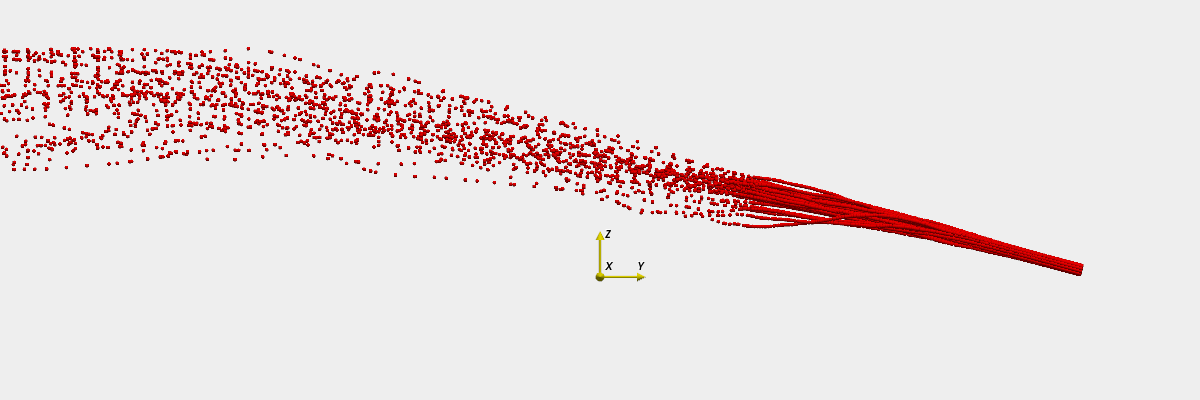

In [17]:
plot = viewer.plot(data=False, opts={}, **{
    "camera_pos": "yz",
    "camera_scale": 1.3,
    "axes_pos": (0, 0, -0.5),
    "axes_scale": 0.3
})

plot.window_size = (1200, 400)

poly_tracks = sample_tracks(tracks, transform=shift_data)

for poly in poly_tracks:
    plot.add_mesh(poly, color="red", point_size=4,
                  render_points_as_spheres=True)

plot.show()